# Colorizing Images with Generative Adversarial Networks



## Import Dependencies and Set General Parameters

In [1]:
# Import libraries
import os
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime
from tensorflow.keras.layers import (
    Activation, AveragePooling2D, BatchNormalization, Conv2D, Dense, MaxPooling2D,
    Dropout, Flatten, LeakyReLU, UpSampling2D, Input, concatenate)
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from time import time
from skimage.color import rgb2lab, lab2rgb
from pathlib import Path
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import Sequential

# Enable memory growth for GPU
print(tf.config.list_physical_devices('GPU'))
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Constants
IMAGE_SIZE = 32
EPOCHS = 60 # Increase or decrease as appropriate
BATCH_SIZE = 256
SHUFFLE_BUFFER_SIZE = 100

WORKDIR = "/content/drive/My Drive/Colab Notebooks/Workspace/"

# Create directories
Path(WORKDIR).mkdir(parents=True, exist_ok=True)
Path(f"{WORKDIR}/results").mkdir(parents=True, exist_ok=True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Define Dataset Loader

In [2]:
def generate_dataset(images, debug=False):
    """
    This function converts a list of RGB images to the LAB color space, and separates the L channel from the A and B channels.
    The images are normalized and reshaped to the appropriate dimensions for the model.

    Parameters:
    images (list): A list of RGB images
    debug (bool): If True, the function will display the original and converted images

    Returns:
    X (np.array): A numpy array of L channels of the images
    Y (np.array): A numpy array of A and B channels of the images
    """
    X = []
    Y = []

    for i in images:
        lab_image_array = rgb2lab(i / 255)  # Convert the image from RGB to LAB color space
        x = lab_image_array[:, :, 0]  # Get the L channel
        y = lab_image_array[:, :, 1:]  # Get the A and B channels
        y /= 128  # normalize

        if debug:  # If debug is True, display the original and converted images
            fig = plt.figure()
            fig.add_subplot(1, 2, 1)
            plt.imshow(i / 255)

            fig.add_subplot(1, 2, 2)
            plt.imshow(lab2rgb(np.dstack((x, y * 128))))
            plt.show()

        X.append(x.reshape(IMAGE_SIZE, IMAGE_SIZE, 1))  # Reshape the L channel and append to the list
        Y.append(y)  # Append the A and B channels to the list

    X = np.array(X, dtype=np.float32)  # Convert the list to a numpy array
    Y = np.array(Y, dtype=np.float32)  # Convert the list to a numpy array

    return X, Y


def load_data(force=False):
    """
    This function loads the CIFAR-10 dataset, processes it, and saves/loads the processed data to/from the disk.

    Parameters:
    force (bool): If True, the function will reprocess the data even if it already exists on the disk

    Returns:
    X_train, Y_train, X_test, Y_test (np.array): Numpy arrays of the training and testing data
    """
    is_saved_arrays_exist = os.path.isfile(os.path.join(WORKDIR, 'X_train.npy'))  # Check if the processed data already exists on the disk

    if not is_saved_arrays_exist or force:  # If the processed data does not exist or if force is True, process the data
        (train_images, _), (test_images, _) = cifar10.load_data()  # Load the CIFAR-10 dataset
        X_train, Y_train = generate_dataset(train_images)  # Process the training images
        X_test, Y_test = generate_dataset(test_images)  # Process the testing images
        print('Saving processed data to Drive')
        np.save(os.path.join(WORKDIR, 'X_train.npy'), X_train)  # Save the processed training data to the disk
        np.save(os.path.join(WORKDIR, 'Y_train.npy'), Y_train)  # Save the processed training data to the disk
        np.save(os.path.join(WORKDIR, 'X_test.npy'), X_test)  # Save the processed testing data to the disk
        np.save(os.path.join(WORKDIR, 'Y_test.npy'), Y_test)  # Save the processed testing data to the disk
    else:  # If the processed data exists and force is False, load the data from the disk
        print('Loading processed data from Drive')
        X_train = np.load(os.path.join(WORKDIR, 'X_train.npy'))  # Load the processed training data from the disk
        Y_train = np.load(os.path.join(WORKDIR, 'Y_train.npy'))  # Load the processed training data from the disk
        X_test = np.load(os.path.join(WORKDIR, 'X_test.npy'))  # Load the processed testing data from the disk
        Y_test = np.load(os.path.join(WORKDIR, 'Y_test.npy'))  # Load the processed testing data from the disk

    return X_train, Y_train, X_test, Y_test

## Load Dataset

In [3]:
# Load the processed training and testing data
X_train, Y_train, X_test, Y_test = load_data()

# Create TensorFlow datasets from the training and testing data
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

# Shuffle the training dataset and batch both datasets
# SHUFFLE_BUFFER_SIZE determines the randomness of the shuffling
# BATCH_SIZE determines the number of samples that will be propagated through the network at once
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step
Saving processed data to Drive


In [4]:
for batch in train_dataset:
    print(batch[0].shape)
    print(batch[1].shape)
    break

(256, 32, 32, 1)
(256, 32, 32, 2)


## Define Generator Model

- Se implementa una U-Net con skip-connections [5 bloques downsampling, 5 bloques upsampling]

In [5]:
def build_generator_model():
    """
    This function builds the generator model for the GAN. The generator is responsible for generating new, fake images.
    It uses a series of Conv2D, BatchNormalization, and UpSampling2D layers.

    Returns:
    model (Sequential): The generator model
    """
    input = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))

    down_1 = Conv2D(32, (3,3), strides=2, padding='same', activation='relu')(input)
    down_1 = BatchNormalization()(down_1)

    down_2 = Conv2D(64, (3,3), strides=2, padding='same', activation='relu')(down_1)
    down_2 = BatchNormalization()(down_2)

    down_3 = Conv2D(128, (3,3), strides=2, padding='same', activation='relu')(down_2)
    down_3 = BatchNormalization()(down_3)

    down_4 = Conv2D(256, (3,3), strides=2, padding='same', activation='relu')(down_3)
    down_4 = BatchNormalization()(down_4)

    down_5 = Conv2D(256, (3,3), strides=2, padding='same', activation='relu')(down_4)
    down_5 = BatchNormalization()(down_5)

    ### Puente Downsampling - Upsampling

    up_1 = UpSampling2D(size=(2,2))(down_5)
    up_1 = Conv2D(256, (3,3), strides=1, padding='same', activation='relu')(up_1)
    up_1 = BatchNormalization()(up_1)
    up_1 = concatenate([up_1, down_4])

    up_2 = UpSampling2D(size=(2,2))(up_1)
    up_2 = Conv2D(256, (3,3), strides=1, padding='same', activation='relu')(up_2)
    up_2 = BatchNormalization()(up_2)
    up_2 = concatenate([up_2, down_3])

    up_3 = UpSampling2D(size=(2,2))(up_2)
    up_3 = Conv2D(128, (3,3), strides=1, padding='same', activation='relu')(up_3)
    up_3 = BatchNormalization()(up_3)
    up_3 = concatenate([up_3, down_2])

    up_4 = UpSampling2D(size=(2,2))(up_3)
    up_4 = Conv2D(64, (3,3), strides=1, padding='same', activation='relu')(up_4)
    up_4 = BatchNormalization()(up_4)
    up_4 = concatenate([up_4, down_1])

    up_5 = UpSampling2D(size=(2,2))(up_4)
    up_5 = Conv2D(32, (3,3), strides=1, padding='same', activation='relu')(up_5)
    up_5 = BatchNormalization()(up_5)


    # Output layer
        # 2 filters: A and B LAB channels of the image
        # Activation layer = tanh because the pixels of the output images range from -1 to 1

    output = Conv2D(2, (3,3), padding="same", activation='tanh')(up_5)

    model = Model(input, output, name="ColorGeneratorGAN")
    return model

## Define Discriminator Model

In [6]:
def build_discriminator_model():
    """
    This function builds the discriminator model for the GAN. The discriminator is responsible for distinguishing real images from fake ones.
    It is recommended to use a series of Conv2D, Dropout, AveragePooling2D, Flatten, Dense, LeakyReLU, BatchNormalization, and Activation layers to create the model.

    Returns:
    model (Sequential): The discriminator model
    """

    model = Sequential()

    model.add(Conv2D(32, (3,3), strides=1, activation='relu', padding='same', input_shape=(IMAGE_SIZE,IMAGE_SIZE, 2)))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3,3), strides=1, activation='relu', padding='same'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())

    model.add(MaxPooling2D())
    model.add(Conv2D(64, (3,3), strides=1, activation='relu', padding='same'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), strides=1, activation='relu', padding='same'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())

    model.add(MaxPooling2D())


    # Cabeza clasificadora
    model.add(Flatten())

    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())

    model.add(Dense(1, activation='sigmoid'))

    return model

## Define Generator and Discriminator Loss Functions

In [7]:
gan_loss_weight = 1 # weight of the GAN loss
l2_lambda = 150     # regularization parameter for the generator's L2 loss

# Binary Cross Entropy is used as the loss function since we are dealing with a binary classification problem (real vs fake images)
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(disc_real_output, disc_generated_output):
    """
    This function calculates the total loss for the discriminator.

    Parameters:
    disc_real_output (Tensor): The discriminator's prediction on the real images
    disc_generated_output (Tensor): The discriminator's prediction on the generated (fake) images

    Returns:
    total_disc_loss (Tensor): The total loss for the discriminator
    """

    total_disc_loss = 0

    # Calculate the cross entropy loss for the real images
    real_loss = cross_entropy(tf.ones_like(disc_real_output), disc_real_output)

    # Calculate the cross entropy loss for the generated (synthetic) images
    fake_loss = cross_entropy(tf.zeros_like(disc_generated_output), disc_generated_output)

    # Calculate the total loss for the discriminator by adding the losses for the real and generated images
    total_disc_loss = real_loss + fake_loss

    # Return the total loss for the discriminator
    return total_disc_loss


def generator_loss(disc_generated_output, gen_output, target):
    """
    This function calculates the total loss for the generator.

    Parameters:
    disc_generated_output (Tensor): The discriminator's prediction on the generated (fake) images
    gen_output (Tensor): The generated (fake) images
    target (Tensor): The real images

    Returns:
    total_gen_loss (Tensor): The total loss for the generator
    gan_loss (Tensor): The GAN loss for the generator
    l2_loss (Tensor): The L2 loss for the generator
    """

    total_gen_loss = 0
    gan_loss = 0
    l2_loss = 0

    # Calculate the GAN loss for the generator (i.e., the loss for fooling the discriminator)
    gan_loss = cross_entropy(tf.ones_like(disc_generated_output), disc_generated_output)

    # Calculate the L2 loss for the generator (i.e., the loss for matching the input images with the generated images). Calculate the L2 loss for the generator by comparing the generated images to the real images
    l2_loss = tf.reduce_mean(tf.square(target - gen_output)) # (target - gen_output)**2 / N)

    # Calculate the total loss for the generator by adding the GAN loss (multiplied by its corresponding weight) and the L2 loss (multiplied by the regularization parameter)
    total_gen_loss = gan_loss_weight * gan_loss + l2_lambda * l2_loss

    return total_gen_loss, gan_loss, l2_loss

## Build Generator and Discriminator Models

In [8]:
# Instantiate the generator and discriminator models
generator = build_generator_model()
discriminator = build_discriminator_model()

# Print out the model summaries
generator.summary()
discriminator.summary()

# Define the optimizers for the generator and discriminator
# Adam optimizer is used with a learning rate of 2e-4 and beta_1 (the exponential decay rate for the first moment estimates) of 0.5
# It is recommended to experiment with different values for the learning rate. Beta_1 value of 0.5 is recommended for GANs
# It is possible that the optimal learning rate for the generator and discriminator is different from each other
gen_learning_rate = 2e-4
gene_beta_1 = 0.5

disc_learning_rate = 2e-4
disc_beta_1 = 0.5

generator_optimizer = tf.keras.optimizers.Adam(gen_learning_rate, beta_1=gene_beta_1)
discriminator_optimizer = tf.keras.optimizers.Adam(disc_learning_rate, beta_1=disc_beta_1)

# Define the directory for storing the training checkpoints
checkpoint_dir = os.path.join(WORKDIR, 'training-checkpoints')
# Define the prefix for the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# Create a checkpoint object which will be used to save and load the models and optimizers
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
# Create a manager for the checkpoint object, which will be responsible for saving and loading the checkpoints
# max_to_keep parameter is set to 3, meaning that only the 3 most recent checkpoints will be kept
manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "ColorGeneratorGAN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 16, 16, 32)     │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 16, 16, 32)     │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 8, 8, 64)       │         18,496 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 8, 8, 64)       │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 4, 4, 128)      │         73,856 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 4, 4, 128)      │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 2, 2, 256)      │        295,168 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 2, 2, 256)      │          1,024 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 1, 1, 256)      │        590,080 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 1, 1, 256)      │          1,024 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 2, 2, 256)      │              0 │ batch_normalization_4… │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 2, 2, 256)      │        590,080 │ up_sampling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 2, 2, 256)      │          1,024 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 2, 2, 512)      │              0 │ batch_normalization_5… │
│                           │                        │                │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_1      

 Total params: 3,335,202 (12.72 MB)

 Trainable params: 3,332,258 (12.71 MB)

 Non-trainable params: 2,944 (11.50 KB)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)                   │ (None, 32, 32, 32)          │             608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 625,281 (2.39 MB)

 Trainable params: 624,129 (2.38 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [9]:
# Define the directory and file for storing the TensorBoard summary logs
summary_log_file = os.path.join(WORKDIR, 'tf-summary', datetime.now().strftime("%Y%m%d-%H%M%S"))
# Create a summary writer for writing the summary logs
summary_writer = tf.summary.create_file_writer(summary_log_file)

#from tensorflow.keras.layers import Concatenate
#generated_image_with_L = Concatenate(axis=-1)([ ........., .............])

@tf.function
def train_step(input_image, target, epoch):
    """ image (L --> imagen_fake)

    ---
    input_image (L) y target (A y B)

    Entrada de la generadora: L
    Salida de la generadora: A* y B*

    Entrada 1 de la discriminadora: (L, A y B originales)
    Entrada 2 de la discriminadora: (L, A* y B*)
    ---

    This function performs one training step for the generator and discriminator.

    Parameters:
    input_image (Tensor): The input image
    target (Tensor): The target image
    epoch (int): The current epoch number

    Returns:
    gen_total_loss (Tensor): The total loss for the generator
    disc_loss (Tensor): The loss for the discriminator
    """

    # Open a GradientTape context for automatic differentiation
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_total_loss = 0
        gen_gan_loss = 0
        gen_l2_loss = 0
        disc_loss = 0

        # Generate an image using the generator. Remember to set training=True, since during training time BatchNormalization layers are applied using the batch mean and variance)
        fake_AB = generator(input_image, training=True) # (32,32,2)

        # fake_image = tf.concat(axis=-1, values=[input_image, fake_AB])
        # generated_image_with_L = Concatenate(axis=-1)(input_image, fake_AB)

        # Get the discriminator's predictions on the real and generated images
        fake_pred = discriminator(fake_AB, training=True)
        real_pred = discriminator(target, training=True)

        # real_image = tf.concat(axis=-1, values=[input_image, target])
        # real_image_with_L = Concatenate(axis=-1)(input_image, fake_AB)

        # Calculate the losses for the generator and discriminator
        disc_loss = discriminator_loss(real_pred, fake_pred)
        gen_total_loss, gen_gan_loss, gen_l2_loss  = generator_loss(fake_pred, fake_AB, target) # l2_loss

    # Calculate the gradients of the generator's and discriminator's losses with respect to the trainable variables of each model
    # Use the gradient() method of the GradientTape object of each model to calculate the gradients of the losses with respect to the trainable variables of the corresponding model
    # Model's trainable variables can be accessed using the trainable_variables attribute

    gradients_generator = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    gradients_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply the gradients to the model's trainable variables
    # Use the apply_gradients() method of the optimizer object to apply the gradients
    # The apply_gradients() method takes a list of (gradient, variable) pairs
    # zip() function can be used to iterate over two lists simultaneously (i.e., the gradients and the model's trainable variables)

    generator_optimizer.apply_gradients(zip(gradients_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_discriminator, discriminator.trainable_variables))

    #Write the losses to the summary logs
    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
        tf.summary.scalar('gen_l2_loss', gen_l2_loss, step=epoch)
        tf.summary.scalar('disc_loss', disc_loss, step=epoch)

    return gen_total_loss, disc_loss

In [10]:
# The checkpoint manager will load the latest checkpoint if it exists
# This will be used to resume training if the training process was interrupted
# If no checkpoint exists, the models will be initialized from scratch

# Restore the latest checkpoint using the checkpoint manager
checkpoint.restore(manager.latest_checkpoint)

# If a checkpoint was found and restored, print a message indicating the checkpoint file
if manager.latest_checkpoint:
    print('Restored from {}'.format(manager.latest_checkpoint))

# If no checkpoint was found, print a message indicating that the models are being initialized from scratch
else:
    print('Initializing from scratch')

Initializing from scratch


In [11]:
import time
# Loop over the epochs
history_loss_generator = []
history_loss_discriminator = []

trace = 5

number_of_batches = len([_ for _ in iter(train_dataset)])


total_time = time.time()

for epoch in range(EPOCHS):

    start_time = time.time()

    gen_loss_total = 0
    disc_loss_total = 0

    # Loop over the training dataset

    for input_batch, target_batch in train_dataset:

        gen_total_loss, disc_loss = train_step(input_batch, target_batch, epoch)

        # Total losses
        gen_loss_total += gen_total_loss
        disc_loss_total += disc_loss

    history_loss_generator.append(gen_total_loss/number_of_batches)
    history_loss_discriminator.append(disc_loss/number_of_batches)

    time_taken = time.time() - start_time

    # Print the epoch number, average generator loss, average discriminator loss, and time taken
    if epoch % trace == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)
      print(f'Epoch {epoch + 1}: gen loss: {gen_loss_total / BATCH_SIZE}, disc loss: {disc_loss_total / BATCH_SIZE}, time: {time_taken:.2f}s')

print(f"Tiempo total de entrenamiento: {(time.time() - total_time) / 60:.2f} minutos")

Epoch 1: gen loss: 5.4293975830078125, disc loss: 1.187577724456787, time: 59.98s
Epoch 6: gen loss: 1.7008501291275024, disc loss: 1.0770748853683472, time: 43.54s
Epoch 11: gen loss: 1.530577301979065, disc loss: 1.0635404586791992, time: 45.30s
Epoch 16: gen loss: 1.3307727575302124, disc loss: 1.0614436864852905, time: 45.40s
Epoch 21: gen loss: 1.1913917064666748, disc loss: 1.06138014793396, time: 45.95s
Epoch 26: gen loss: 1.098980188369751, disc loss: 1.06138014793396, time: 44.60s
Epoch 31: gen loss: 1.0326178073883057, disc loss: 1.06138014793396, time: 43.59s
Epoch 36: gen loss: 0.9822796583175659, disc loss: 1.0613911151885986, time: 44.84s
Epoch 41: gen loss: 0.9427807331085205, disc loss: 1.0613861083984375, time: 44.19s
Epoch 46: gen loss: 0.9138492345809937, disc loss: 1.0613844394683838, time: 44.54s
Epoch 51: gen loss: 0.8849538564682007, disc loss: 1.0613855123519897, time: 44.48s
Epoch 56: gen loss: 0.8685608506202698, disc loss: 1.061384916305542, time: 43.25s
Tiem

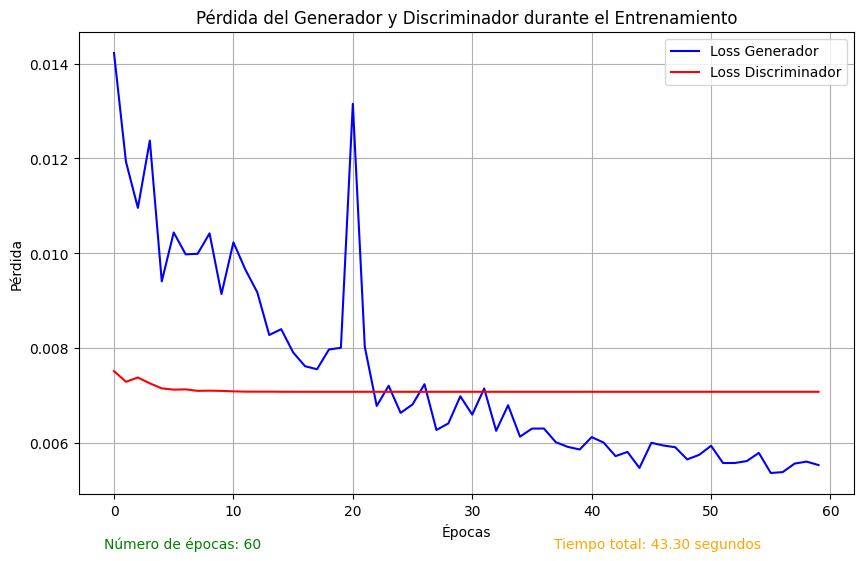

In [12]:
import matplotlib.pyplot as plt
import time

def loss_plot(history_loss_generator, history_loss_discriminator, epochs):

    plt.figure(figsize=(10, 6))

    plt.plot(history_loss_generator, label='Loss Generador', color='blue')
    plt.plot(history_loss_discriminator, label='Loss Discriminador', color='red')

    plt.title('Pérdida del Generador y Discriminador durante el Entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    plt.figtext(0.15, 0.02, f'Número de épocas: {epochs}', fontsize=10, color='green')
    plt.figtext(0.6, 0.02, f'Tiempo total: {time_taken:.2f} segundos', fontsize=10, color='orange')

    plt.grid(True)
    plt.show()


loss_plot(history_loss_generator, history_loss_discriminator, EPOCHS)


## Plot Results

In [13]:
# Define the number of samples to generate
n_samples = 150
# Generate colorized versions of the first n_samples grayscale images in the test set
Y_hat = generator(X_test[:n_samples])

# Define the number of rows in the grid, which is equal to the number of samples
num_rows = len(Y_hat)

# Define the number of columns in the grid and the size of each image
num_cols = 3  # Number of columns in the grid
img_size = 1  # Size of each image in the grid

# Create a grid of subplots with num_rows rows and num_cols columns
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * img_size, num_rows * img_size))
fig.subplots_adjust(hspace=0.3, wspace=0.1)  # Adjust spacing between subplots

# Loop over the grayscale images, original color images, and colorized images
for row, (x, y, y_hat) in enumerate(zip(X_test[:n_samples], Y_test[:n_samples], Y_hat)):

    # Convert the original color image from Lab to RGB
    orig_lab = np.dstack((x, y * 128))
    orig_rgb = lab2rgb(orig_lab)

    # Convert the grayscale image from Lab to RGB
    grayscale_lab = np.dstack((x, np.zeros((IMAGE_SIZE, IMAGE_SIZE, 2))))
    grayscale_rgb = lab2rgb(grayscale_lab)

    # Convert the colorized image from Lab to RGB
    predicted_lab = np.dstack((x, y_hat * 128))
    predicted_rgb = lab2rgb(predicted_lab)

    # Display the grayscale image in the first column of the current row
    ax = axes[row, 0]  # Get the appropriate axis for the current subplot
    ax.axis('off')  # Turn off axis labels
    ax.imshow(grayscale_rgb)
    ax.set_title('Grayscale')

    # Display the original color image in the second column of the current row
    ax = axes[row, 1]  # Move to the next column for original RGB
    ax.axis('off')
    ax.imshow(orig_rgb)
    ax.set_title('Original')

    # Display the colorized image in the third column of the current row
    ax = axes[row, 2]  # Move to the next column for predicted colorized image
    ax.axis('off')
    ax.imshow(predicted_rgb)
    ax.set_title('Predicted')

    # Print the current row number to the console
    sys.stdout.flush()
    sys.stdout.write('\r{} / {}'.format(row + 1, num_rows))

# Hide empty subplots if any
for ax_row in axes:
    for ax in ax_row:
        if not ax.has_data():
            ax.axis('off')

# Adjust the padding between subplots
plt.tight_layout(pad=0.5)
# Save the figure as an image file
plt.savefig(os.path.join(WORKDIR, 'results', 'image_grid.png'))
# Display the figure
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Save the Generator and Discriminator Trained Models

In [14]:
# Save the checkpoints of the models and optimizers so that they can be loaded later
# Save the generator model in the SavedModel format
tf.saved_model.save(generator, os.path.join(WORKDIR, "generator-saved-model"))

# Save the discriminator model in the SavedModel format
tf.saved_model.save(discriminator, os.path.join(WORKDIR, "disciminator-saved-model"))